## Importing modules

In [1]:
import numpy as np
import pydicom
import glob
import matplotlib.pyplot as plt
import cv2
from read_roi import read_roi_file
from ipywidgets import interact
import ipyvolume as ipv
import scipy.ndimage
from plotly.figure_factory import create_trisurf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

### Getting dcm files

In [2]:

dir_path = '/Users/giuseppefilitto/Pazienti_anonym_sorted/BO11/T2AX'
files = glob.glob(dir_path + '/*.dcm')

## Reading slice

In [3]:
def rescale(im, max, min):
    return ((im.astype(float) - min) * (1. / (max - min)) * 255.).astype('uint8')


def read_slices(filename):
    name, ext = filename.split('.')

    if ext != 'dcm':
        raise ValueError('Input filename must be a DICOM file')

    slide = pydicom.dcmread(filename).pixel_array

    return slide


# ordering as istance number
z = [float(pydicom.read_file(f, force=True).get(
    "InstanceNumber", "0") - 1) for f in files]
order = np.argsort(z)
files = np.asarray(files)[order]

slice = [read_slices(f) for f in files]

Max = max([x.max() for x in slice])
Min = min([x.min() for x in slice])

slice = [rescale(x, Max, Min) for x in slice]

slice = np.asarray(slice)


### Slice info

In [4]:

depth, height, width = slice.shape
print(
    f"The image object has the following dimensions: height: {height}, width:{width}, depth:{depth}")

The image object has the following dimensions: height: 512, width:512, depth:30


# 2D Plotting

## Plotting Slice

### Random layer plot

Plotting Layer 4 of Image


(-0.5, 511.5, 511.5, -0.5)

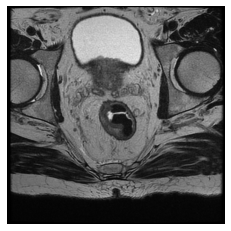

In [12]:


maxval = depth  # Select random layer number
i = np.random.randint(0, maxval)

print(f"Plotting Layer {i} of Image")
plt.imshow(slice[i, :, :], cmap='gray')
plt.axis('off')


### Interactive slice plot

In [ ]:

@interact(layer=(0, slice.shape[0] - 1))
def explore_slice(layer):
    plt.figure(figsize=(10, 5))
    plt.imshow(slice[layer, :, :], cmap='gray')
    plt.title('Explore Layers', fontsize=20)
    plt.axis('off')

    return layer


## ROIS

### Getting ROIs

In [5]:


def _dict(dict_list):
    '''

    useful to get true_dict since roi is {name file : true_dict}.

    '''

    true_dict = []

    for i in dict_list:
        _dict = list(i.values())

        for j in _dict:
            keys = j.keys()
            vals = j.values()

            _dict = {key: val for key, val in zip(keys, vals)}
            true_dict.append(_dict)

    return true_dict


roi_path = '/Users/giuseppefilitto/Pazienti_anonym_sorted/BO11/T2ROI'
rois_list = glob.glob(roi_path + '/*.roi')

rois = [read_roi_file(roi) for roi in rois_list]
rois = _dict(rois)

# ordering dictionaries by positions and removing rois without x y coords
rois = sorted(rois, key=lambda d: list(d.values())[-1])
rois = list(filter(lambda d: d['type'] != 'composite', rois))

positions = []
xs = []
ys = []
for i in range(len(rois)):
    position = rois[i]['position']
    x = rois[i]['x']
    y = rois[i]['y']

    x.append(x[0])
    y.append(y[0])

    positions.append(position)
    xs.append(x)
    ys.append(y)


### ROIs Plotting 

In [13]:

@interact(layer=(0, slice.shape[0] - 1))
def explore_roi(layer):
    plt.figure(figsize=(10, 5))
    plt.imshow(slice[layer, :, :], cmap='gray')
    if layer in positions:
        plt.plot(xs[layer - positions[0]], ys[layer - positions[0]], color="red",
                 linestyle='dashed', linewidth=1)
    plt.title(f'Explore Layer {layer}', fontsize=20)
    plt.axis('off')

    return layer


interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

### ROIs masks

In [11]:

@interact(layer=(0, slice.shape[0] - 1))
def explore_mask(layer):
    
    image = slice[layer, :, :].copy()

    if layer in positions:
        pts = np.array([(x, y) for(x, y) in zip(xs[layer - positions[0]], ys[layer - positions[0]])])

        cv2.drawContours(image, [pts], -1, (255, 255, 255), -1)
        cv2.polylines(image, [pts], isClosed=True, color=(255, 255, 255), thickness=1)
        mask = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)[1]
        plt.imshow(mask, cmap="gray")
        plt.title(f'Original Layer {layer}', fontsize=20)
    else:
        print("no orignial mask found in this layer")    

interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

# 3D Plotting

### ipyvolume

In [ ]:

mri_vol = ipv.volshow(
    slice, lighting=True,
    data_min=0, data_max=255, stereo=True)

ipv.show()



### Resampling for making 3d mesh 

In [ ]:


def resample(image, dcmfiles, new_spacing=[1, 1, 1]):
    # Determine current pixel spacing

    slice_thick = float(pydicom.read_file(dcmfiles[0], force=True).get(
        "SliceThickness"))

    pix_space = pydicom.read_file(dcmfiles[0], force=True).get(
        "PixelSpacing")

    pix_space = [float(x) for x in pix_space]

    spacing = map(float, ([slice_thick] + pix_space))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)

    return image, new_spacing


print("Shape before resampling\t", slice.shape)
imgs_after_resamp, spacing = resample(slice, files, [1, 1, 1])
print("Shape after resampling\t", imgs_after_resamp.shape)



### 3D Mesh

In [ ]:


def make_mesh(image, step_size=1):

    print("Transposing surface")
    p = image.transpose(2, 1, 0)

    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(
        p, step_size=step_size, allow_degenerate=True)
    return verts, faces


def plotly_3d(verts, faces):
    x, y, z = zip(*verts)

    print("Drawing")

    # Make the colormap single color since the axes are positional not intensity.

    colormap = ['rgb(0, 0, 0)', 'rgb(255, 255, 255)']

    fig = create_trisurf(x=x,
                         y=y,
                         z=z,
                         plot_edges=True,
                         simplices=faces,
                         colormap=colormap,
                         title="Interactive Visualization")
    iplot(fig)



### 3D mesh plotly

In [ ]:
v, f = make_mesh(imgs_after_resamp, 2)
plotly_3d(v, f)